In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.svm import SVR
from statistics import mean
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import xgboost as xgb
import pandas as pd
import arviz as az
import numpy as np
import arviz as az
import pymc as pm
import sqlite3
import joblib
import random 
import math
import os

In [57]:
col_order = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB',
       'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB',
       'WAR', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'WS_MVP', 'Pos', 'status']

inactive_data = pd.read_csv('inactive_player_data.csv')
inactive_data = inactive_data[col_order]
active_data = pd.read_csv('new_active_player_data.csv')
active_data = active_data[col_order]

In [58]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,WS_MVP,Pos,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,2.0,-0.7,0,0,0,0,0,0,9,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,0.0,2.0,0,0,0,0,0,0,8,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,3.0,2.6,1,0,0,1,0,0,8,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,1.0,2.5,0,0,0,0,0,0,8,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,2.0,3.3,0,0,0,0,0,0,8,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,3.0,2.2,0,1,0,0,0,0,6,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,4.0,1.5,0,0,0,0,0,0,6,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,7.0,4.3,1,1,0,0,0,0,6,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,12.0,5.6,1,1,0,0,0,0,6,retired


In [59]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,WS_MVP,Pos,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,1,1.6,0,0,0,0,0,0,7,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,3,3.8,1,0,0,0,0,0,7,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,2,3.6,0,0,0,0,0,0,7,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,4,4.9,0,1,0,0,0,0,7,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,4,3.7,0,0,0,0,0,0,8,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,7,2.1,0,1,0,1,0,0,3,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,4,2.3,0,0,0,1,0,0,3,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,1,2.7,0,1,0,0,1,0,3,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,3,3.0,0,0,0,0,0,0,3,active


In [60]:
inactive_dummies = pd.get_dummies(inactive_data['Pos'], prefix='Pos')
temp_inact_stat = inactive_data['status']
inactive_data.drop(['Pos', 'status'], axis=1, inplace=True)
inactive_data = pd.concat([inactive_data, inactive_dummies, temp_inact_stat], axis=1)

active_dummies = pd.get_dummies(active_data['Pos'], prefix='Pos')
temp_act_stat = active_data['status']
active_data.drop(['Pos', 'status'], axis=1, inplace=True)
active_data = pd.concat([active_data, active_dummies, temp_act_stat], axis=1)

In [81]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,False,False,True,False,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,False,False,True,False,False,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,False,False,True,False,False,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,False,False,True,False,False,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,False,False,True,False,False,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,False,False,True,False,False,False,False,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,False,False,True,False,False,False,False,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,False,False,True,False,False,False,False,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,False,False,True,False,False,False,False,retired


In [62]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,False,False,True,False,False,False,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,False,False,True,False,False,False,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,False,False,True,False,False,False,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,False,False,True,False,False,False,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,False,False,True,False,False,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,True,False,False,False,False,False,False,False,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,True,False,False,False,False,False,False,False,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,True,False,False,False,False,False,False,False,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,True,False,False,False,False,False,False,False,active


In [63]:
for i in inactive_data.columns[2:46]:
    skew = inactive_data[i].skew()
    print(f'{i} skewness: {skew}')

Season skewness: 0.9901568583922
Age skewness: 0.1810072083496936
G skewness: -1.362974850938581
PA skewness: -1.05763469374795
AB skewness: -1.020124081120541
R skewness: -0.31874233452046746
H skewness: -0.6773855193977166
1B skewness: -0.366240307306468
2B skewness: -0.057788990423966256
3B skewness: 1.6190830724585026
HR skewness: 0.6967106737151384
RBI skewness: -0.006721975829215389
XBH skewness: -0.08014979252737749
SB skewness: 2.4380127925769166
CS skewness: 1.71974008989736
BB skewness: 0.4779402138003494
SO skewness: 0.25578635174060743
BA skewness: -1.1232584805170576
OBP skewness: -1.0023295856945773
SLG skewness: -0.2778134255393927
OPS skewness: -0.5716435244431536
TB skewness: -0.47226362267975885
GIDP skewness: 0.4418857755968422
HBP skewness: 2.5489341313831275
SH skewness: 2.800091029683774
SF skewness: 0.7164057251843686
IBB skewness: 3.324747283986413
WAR skewness: 0.5085146446179789
GGs skewness: 2.236741784388354
SSs skewness: 2.933109058834233
Bat_Titles skewnes

In [64]:
def safe_transform(df, col):
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    transformed = pt.fit_transform(df[[col]].values)
    return transformed.flatten()

def fix_seasons(df):
    for player in df['Player'].unique():
        debut = df.loc[df['Player'] == player, 'Season'].min()
        df.loc[df['Player'] == player, 'Season'] = df.loc[df['Player'] == player, 'Season'] - debut + 1

def find_optimal_clusters(data, max_clusters=8):
    scores = []
    
    for k in range(2, max_clusters+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        clusters = gmm.fit_predict(data)
        score = silhouette_score(data, clusters)
        scores.append(score)
        print(f"Clusters: {k} - Silhouette: {score:.3f}")
    
    optimal_k = np.argmax(scores) + 2
    print(f"Optimal cluster count: {optimal_k}")
    return optimal_k

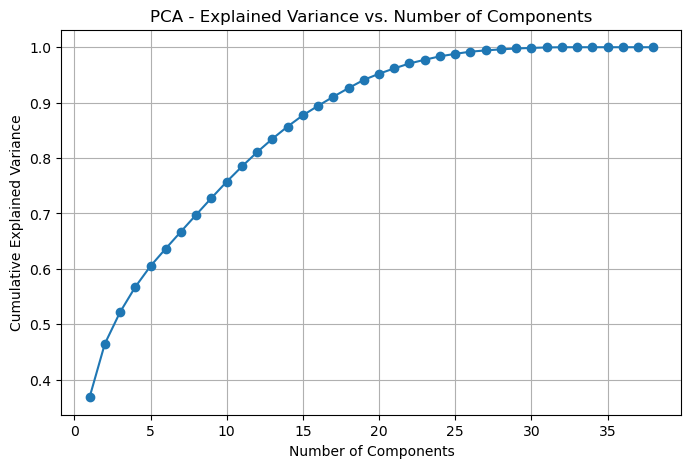

Component 1: 0.3684
Component 2: 0.4647
Component 3: 0.5219
Component 4: 0.5674
Component 5: 0.6051
Component 6: 0.6366
Component 7: 0.6674
Component 8: 0.6978
Component 9: 0.7279
Component 10: 0.7573
Component 11: 0.7848
Component 12: 0.8107
Component 13: 0.8347
Component 14: 0.8569
Component 15: 0.8771
Component 16: 0.8943
Component 17: 0.9107
Component 18: 0.9263
Component 19: 0.9410
Component 20: 0.9521
Component 21: 0.9618
Component 22: 0.9707
Component 23: 0.9774
Component 24: 0.9836
Component 25: 0.9880
Component 26: 0.9920
Component 27: 0.9942
Component 28: 0.9962
Component 29: 0.9977
Component 30: 0.9987
Component 31: 0.9996
Component 32: 1.0000
Component 33: 1.0000
Component 34: 1.0000
Component 35: 1.0000
Component 36: 1.0000
Component 37: 1.0000
Component 38: 1.0000


In [65]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'WS_MVP'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:40]].dropna()

for i in test_inactive_X.columns[2:40]:
    safe_transform(test_inactive_X, i)

test_pca = PCA()
test_pca.fit_transform(test_inactive_X_scaled)

explained_variance = test_pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.4f}")

In [66]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'WS_MVP'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:40]].dropna()

for i in test_inactive_X.columns[2:40]:
    safe_transform(test_inactive_X, i)

pca = PCA(n_components=13)
inactive_X_pca = pca.fit_transform(test_inactive_X)

best_k = find_optimal_clusters(inactive_X_pca)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(inactive_X_pca)
cluster_probs = gmm.predict_proba(inactive_X_pca)

Clusters: 2 - Silhouette: 0.587
Clusters: 3 - Silhouette: 0.365
Clusters: 4 - Silhouette: 0.235
Clusters: 5 - Silhouette: 0.182
Clusters: 6 - Silhouette: 0.076
Clusters: 7 - Silhouette: 0.064
Clusters: 8 - Silhouette: 0.041
Optimal cluster count: 2


In [67]:
for i in range(cluster_probs.shape[1]):
    test_inactive[f'Cluster_{i}_Prob'] = cluster_probs[:, i]

In [68]:
test_inactive

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,True,False,retired,5.855023e-02,0.941450
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,True,False,False,retired,9.393518e-03,0.990606
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,True,False,False,retired,2.187532e-02,0.978125
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,True,False,False,retired,3.862364e-09,1.000000
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,True,False,False,retired,2.032247e-08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,True,False,False,False,False,retired,2.732961e-07,1.000000
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,True,False,False,False,False,retired,6.600402e-03,0.993400
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,True,False,False,False,False,retired,9.226757e-09,1.000000
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,True,False,False,False,False,retired,1.147821e-28,1.000000


In [99]:
test_inactive.columns

Index(['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_1',
       'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'Pos_10', 'status', 'Cluster_0_Prob', 'Cluster_1_Prob'],
      dtype='object')

In [79]:
def calc_bat_avg(hits, at_bats):
    if at_bats == 0:
        return 0.0
    return round((hits/at_bats), 3)

def calc_obp(hits, walks, hbp, at_bats, sf):
    first = hits + walks + hbp
    second = at_bats + hbp + sf
    if second == 0:
        return 0.0
    return round((first/second), 3)

def calc_slug(singles, doubles, triples, hrs, at_bats):
    if at_bats == 0:
        return 0.0
    doubles = doubles * 2
    triples = triples * 3
    home_bs = hrs * 4
    return round(((singles+doubles+triples+home_bs)/at_bats), 3)

def calc_ops(obp, slug):
    return round((obp+slug), 3)



,Season,Age,G,PA,AB,R,H,1B,2B,3B,...,Pos_9,Pos_10,Cluster_0_Prob,Cluster_1_Prob,GGs,SSs,Bat_Titles,All_Stars,MVPs,WS_MVP
0,14,33,137,528,485,66,126,84,25,1,...,True,False,5.855023e-02,0.941450,0,0,0,0,0,0
1,3,22,132,514,477,61,129,92,21,7,...,False,False,9.393518e-03,0.990606,0,0,0,0,0,0
2,4,23,119,519,473,83,131,87,22,3,...,False,False,2.187532e-02,0.978125,1,0,0,1,0,0
3,5,24,149,621,581,76,165,116,25,5,...,False,False,3.862364e-09,1.000000,0,0,0,0,0,0
4,6,25,151,618,567,68,159,106,26,2,...,False,False,2.032247e-08,1.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,5,23,150,643,562,94,156,107,32,1,...,False,False,2.732961e-07,1.000000,0,1,0,0,0,0
5208,6,24,141,549,493,54,128,96,19,3,...,False,False,6.600402e-03,0.993400,0,0,0,0,0,0
5209,7,25,152,609,544,77,166,117,36,2,...,False,False,9.226757e-09,1.000000,1,1,0,0,0,0
5210,8,26,157,663,587,96,194,133,47,1,...,False,False,1.147821e-28,1.000000,1,1,0,0,0,0


In [ ]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'WS_MVP']
awards_inactive = inactive_data[awards]

not_status = pd.concat([test_inactive, awards_inactive], axis=1)

col_names = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_1',
       'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'Pos_10', 'status', 'Cluster_0_Prob', 'Cluster_1_Prob', 'GGs', 'SSs',
        'Bat_Titles' 'All_Stars', 'MVPs', 'WS_MVP', 'status']

In [84]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'WS_MVP']
awards_inactive = inactive_data[awards]

not_status = pd.concat([test_inactive, awards_inactive], axis=1)
not_status.drop(['status'], axis=1, inplace=True)

X = not_status.iloc[:, 2:]
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y = test_inactive['status'].map({'hof': 1, 'retired': 0})

logistic_lasso = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=10_000).fit(X_scaled, y)

selected_features = X.columns[logistic_lasso.coef_[0] != 0]
print("Selected features:", selected_features)

Selected features: Index(['Season', 'Age', 'G', 'AB', 'R', '2B', '3B', 'RBI', 'SB', 'CS', 'BB',
       'SO', 'OBP', 'SLG', 'OPS', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_1',
       'Pos_2', 'Pos_3', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'Pos_10',
       'Cluster_0_Prob', 'Cluster_1_Prob', 'GGs', 'SSs', 'All_Stars', 'MVPs',
       'WS_MVP'],
      dtype='object')


In [88]:
print(len(not_status.columns))
print(len(selected_features))

48
36


In [86]:
corr_mat = not_status[selected_features].corr()

corr_check = {}
for i in corr_mat.index:
    for j in corr_mat.columns:
        if corr_mat.loc[i, j] >= 0.7:
            if i != j:
                print(f"{i} + {j}")

Season + Age
Age + Season
G + AB
G + R
G + 2B
G + RBI
G + Cluster_1_Prob
AB + G
AB + R
AB + 2B
AB + RBI
AB + Cluster_1_Prob
R + G
R + AB
R + 2B
R + RBI
R + BB
R + WAR
R + Cluster_1_Prob
2B + G
2B + AB
2B + R
2B + RBI
2B + Cluster_1_Prob
RBI + G
RBI + AB
RBI + R
RBI + 2B
RBI + SLG
RBI + Cluster_1_Prob
SB + CS
CS + SB
BB + R
OBP + SLG
OBP + OPS
SLG + RBI
SLG + OBP
SLG + OPS
OPS + OBP
OPS + SLG
WAR + R
Cluster_1_Prob + G
Cluster_1_Prob + AB
Cluster_1_Prob + R
Cluster_1_Prob + 2B
Cluster_1_Prob + RBI


In [97]:
to_remove = ['SLG', 'R', 'Age', 'CS', 'OBP', 'SLG', 'R']
final_features = [i for i in selected_features if i not in to_remove] + ['status']

final_inactive = pd.concat([test_inactive, awards_inactive], axis=1)
final_inactive = final_inactive[final_features]

In [98]:
final_inactive

,Season,G,AB,2B,3B,RBI,SB,BB,SO,OPS,...,Pos_9,Pos_10,Cluster_0_Prob,Cluster_1_Prob,GGs,SSs,All_Stars,MVPs,WS_MVP,status
0,14,137,485,25,1,67.0,2.0,31,101.0,0.728,...,True,False,5.855023e-02,0.941450,0,0,0,0,0,retired
1,3,132,477,21,7,57.0,10.0,23,108.0,0.711,...,False,False,9.393518e-03,0.990606,0,0,0,0,0,retired
2,4,119,473,22,3,70.0,10.0,36,93.0,0.792,...,False,False,2.187532e-02,0.978125,1,0,1,0,0,retired
3,5,149,581,25,5,69.0,7.0,23,119.0,0.767,...,False,False,3.862364e-09,1.000000,0,0,0,0,0,retired
4,6,151,567,26,2,83.0,12.0,29,113.0,0.785,...,False,False,2.032247e-08,1.000000,0,0,0,0,0,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,5,150,562,32,1,76.0,21.0,63,77.0,0.770,...,False,False,2.732961e-07,1.000000,0,1,0,0,0,retired
5208,6,141,493,19,3,57.0,17.0,39,73.0,0.685,...,False,False,6.600402e-03,0.993400,0,0,0,0,0,retired
5209,7,152,544,36,2,83.0,22.0,49,57.0,0.803,...,False,False,9.226757e-09,1.000000,1,1,0,0,0,retired
5210,8,157,587,47,1,100.0,34.0,65,54.0,0.874,...,False,False,1.147821e-28,1.000000,1,1,0,0,0,retired
